## Unzip the file

In [ ]:
!unzip /content/02_raw_train.zip

Archive:  /content/02_raw_train.zip
   creating: 02_raw_train/images/
   creating: 02_raw_train/images/0_punching_hole/
   creating: 02_raw_train/images/1_welding_line/
   creating: 02_raw_train/images/2_crescent_gap/
   creating: 02_raw_train/images/3_water_spot/
   creating: 02_raw_train/images/4_oil_spot/
   creating: 02_raw_train/images/5_silk_spot/
   creating: 02_raw_train/images/6_inclusion/
   creating: 02_raw_train/images/7_rolled_pit/
   creating: 02_raw_train/images/8_crease/
   creating: 02_raw_train/images/9_waist_folding/
  inflating: 02_raw_train/0_punching_hole.csv  
  inflating: 02_raw_train/1_welding_line.csv  
  inflating: 02_raw_train/2_crescent_gap.csv  
  inflating: 02_raw_train/3_water_spot.csv  
  inflating: 02_raw_train/4_oil_spot.csv  
  inflating: 02_raw_train/5_silk_spot.csv  
  inflating: 02_raw_train/6_inclusion.csv  
  inflating: 02_raw_train/7_rolled_pit.csv  
  inflating: 02_raw_train/8_crease.csv  
  inflating: 02_raw_train/9_waist_folding.csv  
  infl

## Imports

In [ ]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from torchvision.utils import make_grid
import seaborn as sns

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 224

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 800

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data

In [4]:
class Dataset(Dataset):
    def __init__(self, labels_file, root_dir, transform=None):
        self.annotations = pd.read_csv(labels_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 1]), self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[(index, 2)]))

        if self.transform:
            image = self.transform(image)

        return(image, label)
    
    def __getlabel__(self, index):
        label = (self.annotations.iloc[(index, 1)])        

        return(label)

In [ ]:
preprocessing = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

In [ ]:
labels_file = '/content/gc10-det/02_raw_train/0_punching_hole.csv'
root_dir = '/content/gc10-det/02_raw_train/images/'

dataset = Dataset(labels_file=labels_file, root_dir=root_dir, transform=preprocessing)

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [ ]:
print(f"Len of dataset {dataset.__len__()}")
print(f"Len of dataloader {dataloader.__len__()}")

Len of dataset 140
Len of dataloader 18


In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

## Weight

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [11]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # input is Z, going into a convolution
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


## Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Parameters

In [18]:
g_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
d_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)

total_params = g_params + d_params

print("Total number of parameters: {}".format(total_params))

Total number of parameters: 15424000


## Loss

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(224, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_losses_epoch = []
D_losses_epoch = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 1000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    G_losses_epoch.append(sum(G_losses)/len(G_losses))
    D_losses_epoch.append(sum(D_losses)/len(D_losses))

Starting Training Loop...


ValueError: ignored

## Visualizations

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

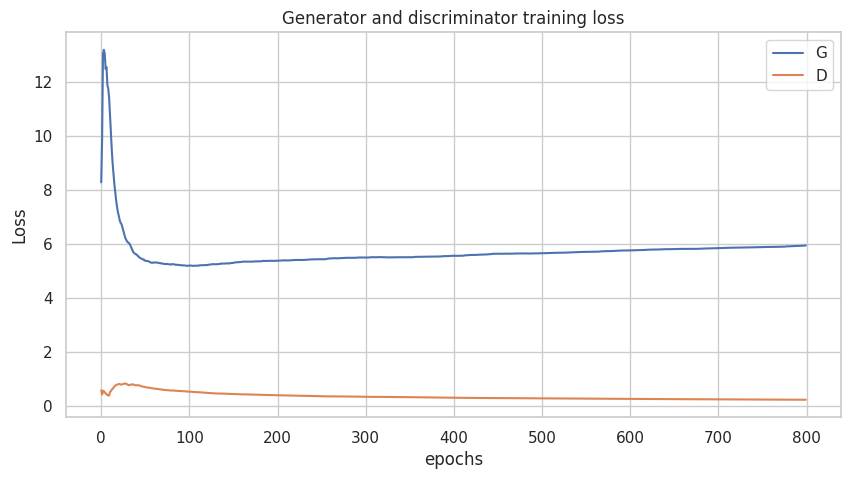

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator training loss")
plt.plot(G_losses_epoch,label="G")
plt.plot(D_losses_epoch,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

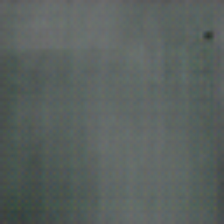

In [ ]:
noise = torch.randn(1, 100, 1, 1, device=device)

tensor_image = netG(noise).squeeze()
tensor_image = (tensor_image*0.5) + 0.5
pil_image = transforms.ToPILImage()(tensor_image)
pil_image = transforms.Resize((224, 224))(pil_image)
pil_image

## Saving Images

In [ ]:
def save_synthetic_data(dataset, nz, save_path, num_instances):
  num_images = num_instances - dataset.__len__()
  noise = torch.randn(num_images, nz, 1, 1, device=device)
  image_tensor  = netG(noise)
  image_list = []
  for i in range(image_tensor.size(0)):
    tensor_image = image_tensor[i].detach().cpu()
    tensor_image = (tensor_image*0.5) + 0.5
    pil_image = transforms.ToPILImage()(tensor_image)
    pil_image = transforms.Resize((224, 224))(pil_image)
    pil_image.save(os.path.join(save_path, dataset.__getlabel__(0), 'dcgan_'+str(dataset.__getlabel__(0))+'_'+str(i)+'.jpg'))


In [ ]:
save_path = "/content/04_dcgan/"
num_instances = 1000

save_synthetic_data(dataset, nz, save_path, num_instances)

In [ ]:
!zip -r 0_punching_hole.zip /content/04_dcgan/0_punching_hole

  adding: content/04_dcgan/0_punching_hole/ (stored 0%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_254.jpg (deflated 9%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_536.jpg (deflated 9%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_341.jpg (deflated 10%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_432.jpg (deflated 7%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_30.jpg (deflated 5%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_127.jpg (deflated 7%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_339.jpg (deflated 9%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_495.jpg (deflated 6%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_251.jpg (deflated 5%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_744.jpg (deflated 6%)
  adding: content/04_dcgan/0_punching_hole/dcgan_0_punching_hole_253.jpg (

In [ ]:
import time
for i in range (10):
  time.sleep(120)
  print(i)

0


KeyboardInterrupt: ignored